<a href="https://colab.research.google.com/github/hadine30/crowd-counting/blob/master/dencityCSRnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! git clone https://github.com/Tikam02/CrowdEstimation

Cloning into 'CrowdEstimation'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 175 (delta 0), reused 0 (delta 0), pack-reused 168
Receiving objects: 100% (175/175), 47.01 MiB | 24.12 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [0]:
import sys
sys.path.append('/content/CrowdEstimation/CSRNet/CSRnet-pytorch')

In [0]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import scipy.spatial
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

In [0]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [0]:
!unzip -qq "/content/drive/My Drive/ShanghaiTech_Crowd_Counting_Dataset.zip"

In [0]:
#set the root to the Shanghai dataset you download
root = '/content'

In [0]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train]

In [0]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [10]:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

/content/part_A_final/train_data/images/IMG_8.jpg
(465, 700)
generate density...
done.


In [0]:
img='/content/part_A_final/train_data/images/IMG_8.jpg'

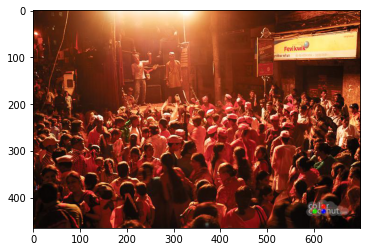

In [12]:
plt.imshow(Image.open(img))

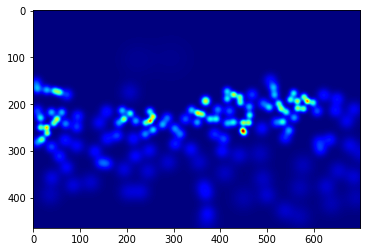

In [13]:
gt_file = h5py.File(img.replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)
plt.show()

In [14]:
np.sum(groundtruth)# don't mind this slight variation

143.1492

In [0]:
#now generate the ShanghaiB's ground truth
path_sets = [part_B_train,part_B_test]

In [0]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [17]:
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

/content/part_B_final/train_data/images/IMG_68.jpg
/content/part_B_final/train_data/images/IMG_314.jpg
/content/part_B_final/train_data/images/IMG_152.jpg
/content/part_B_final/train_data/images/IMG_273.jpg
/content/part_B_final/train_data/images/IMG_271.jpg
/content/part_B_final/train_data/images/IMG_338.jpg
/content/part_B_final/train_data/images/IMG_177.jpg
/content/part_B_final/train_data/images/IMG_299.jpg
/content/part_B_final/train_data/images/IMG_46.jpg
/content/part_B_final/train_data/images/IMG_324.jpg
/content/part_B_final/train_data/images/IMG_142.jpg
/content/part_B_final/train_data/images/IMG_248.jpg
/content/part_B_final/train_data/images/IMG_179.jpg
/content/part_B_final/train_data/images/IMG_110.jpg
/content/part_B_final/train_data/images/IMG_32.jpg
/content/part_B_final/train_data/images/IMG_114.jpg
/content/part_B_final/train_data/images/IMG_238.jpg
/content/part_B_final/train_data/images/IMG_197.jpg
/content/part_B_final/train_data/images/IMG_174.jpg
/content/part_B

In [18]:
import json
path = {u"answer": [42.2], u"abs": 42}
print(json.dumps(path))

{"answer": [42.2], "abs": 42}


In [0]:
import torch.nn as nn
import torch
from torchvision import models
from utils import save_net,load_net

In [0]:
from past.builtins import xrange

In [0]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(list(self.frontend.state_dict().items()))):
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [0]:
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [23]:
model = CSRNet()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
x = torch.rand((1,3,255,255))

In [25]:
model(x).shape

torch.Size([1, 1, 31, 31])